In [28]:
from qiskit import*
from qiskit.tools.visualization import plot_histogram
simulator=Aer.get_backend('qasm_simulator')

In [29]:
def graph_color_prep(variable_qubits):

  num_vars = len(variable_qubits)
  prep = QuantumCircuit(num_vars)

  for i in range(num_vars):
    prep.h(i)

  return prep

In [30]:
def disagree_check(qc, qubits_a, qubits_b, check_qubit):

  # 1. Check if the qubits are in the 11 11 state.
  qc.mct(qubits_a + qubits_b, check_qubit)

  # 2. Check if the qubits are in the 01 01 state.
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])

  # 3. Check if the qubits are in the 10 10 state.
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
    
  # 4. Check if the qubits are in the 00 00 state.
  qc.x(qubits_a)
  qc.x(qubits_b)
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a)
  qc.x(qubits_b)

  # 5. The oracle is 1 if none of the above conditions are met for two vertices.
  qc.x(check_qubit)

In [31]:
def undo_disagree_check(qc, qubits_a, qubits_b, check_qubit):#, ancillas):
  # 5. The oracle is 1 if none of the above conditions are met for two vertices.
  qc.x(check_qubit)
  # 4. Check if the qubits are in the 00 00 state.
  qc.x(qubits_a)
  qc.x(qubits_b)
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a)
  qc.x(qubits_b)


  # 3. Check if the qubits are in the 10 10 state.
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[0])
  qc.x(qubits_b[0])

  # 2. Check if the qubits are in the 01 01 state.
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])
  qc.mct(qubits_a + qubits_b, check_qubit)
  qc.x(qubits_a[1])
  qc.x(qubits_b[1])

  # 1. Check if the qubits are in the 11 11 state.
  qc.mct(qubits_a + qubits_b, check_qubit)

In [32]:
def graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit):

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  num_vars = len(variable_qubits)
  num_checks = len(check_qubits)
  num_outputs = 1

  oracle = QuantumCircuit(num_vars + num_checks + num_outputs)
  oracle.x(output_qubit)
  oracle.h(output_qubit)


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  # Storing the ancilla qubits used for each check
  #ancillas = []
  for i in range(len(disagree_list)):
    disagree_check(oracle,disagree_list[i][0],disagree_list[i][1],check_qubits[i])
    #ancillas += [ disagree_check(oracle,
    #                              disagree_list[i][0],
    #                              disagree_list[i][1],
    #                              check_qubits[i]) ]


  # 3. Flip the output bit if all disagreements are satisfied.
  oracle.mct(check_qubits, output_qubit)


  # 4. Resetting all the extra qubits for the next iteration.
  # Need to include the specific ancillas used for each check
  for i in range(len(disagree_list)):
    undo_disagree_check(oracle,
                           disagree_list[i][0],
                           disagree_list[i][1],
                           check_qubits[i])#,
   #                        ancillas[i])


  return oracle

In [33]:
def check_disagree_list_general(state, disagree_list):

  for i in range(len(disagree_list)):

    if (state[disagree_list[i][0][0]] == state[disagree_list[i][1][0]]
        and state[disagree_list[i][0][1]] == state[disagree_list[i][1][1]]):
        return False 

  return True

In [34]:
from qiskit import  Aer
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

variable_qubits = [0, 1, 2, 3, 4, 5, 6, 7]
disagree_list = [ [[0, 1], [2, 3]],
                  [[0, 1], [4, 5]],
                  [[0, 1], [6, 7]],
                  [[2,3], [4, 5]],
                  [[2, 3], [6, 7]],
                  [[4, 5], [6, 7]]
                 ]
check_qubits = [8, 9, 10, 11, 12, 13]
output_qubit = 14



# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(variable_qubits)
oracle = graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit)


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = prep,
                               objective_qubits = variable_qubits)#,
#                               is_good_state = check_disagreement
#                               )

grover = Grover(iterations = 3, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

C:\Users\propietario\AppData\Local\Temp\ipykernel_4512\3583270959.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\propietario\AppData\Local\Temp\ipykernel_4512\3583270959.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\propietario\AppData\Local\Temp\ipykernel_4512\3583270959.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(qubits_a + qubits_b, check_qubit)
C:\Users\

In [35]:
from qiskit.visualization import plot_histogram

def plot_results(result, satisfies_disagree_list):

  # Plotting results
  counts = result.circuit_results[0]
  plot = plot_histogram(counts, figsize=(int(6*len(counts.keys())**(1/2)), 8), sort='value_desc')
  ax = plot.gca()
  ax.tick_params(axis='x', which='major', labelsize=10)
  ax.set_xlabel("State", fontsize = 'x-large')
  ax.set_ylabel("Count", fontsize = 'x-large')


  correct_count = 0
  states = ax.xaxis.get_ticklabels()
  for i in range(len(states)):
    if satisfies_disagree_list(states[i].get_text()):
      ax.containers[i][0].set(color = 'orange')
      correct_count += 1
    else:
      ax.containers[i][0].set(color = 'blue')

  leg = plot.legend(['Incorrect (' + str(len(states) - correct_count) + ' counted)',
                     'Correct (' + str(correct_count) + ' counted)'],
                    fontsize = 'x-large',
                    loc = 'upper left')
  leg.legendHandles[0].set_color('blue')
  leg.legendHandles[1].set_color('orange')

  display(plot)

C:\Users\propietario\AppData\Local\Temp\ipykernel_4512\65279167.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
C:\Users\propietario\AppData\Local\Temp\ipykernel_4512\65279167.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('orange')


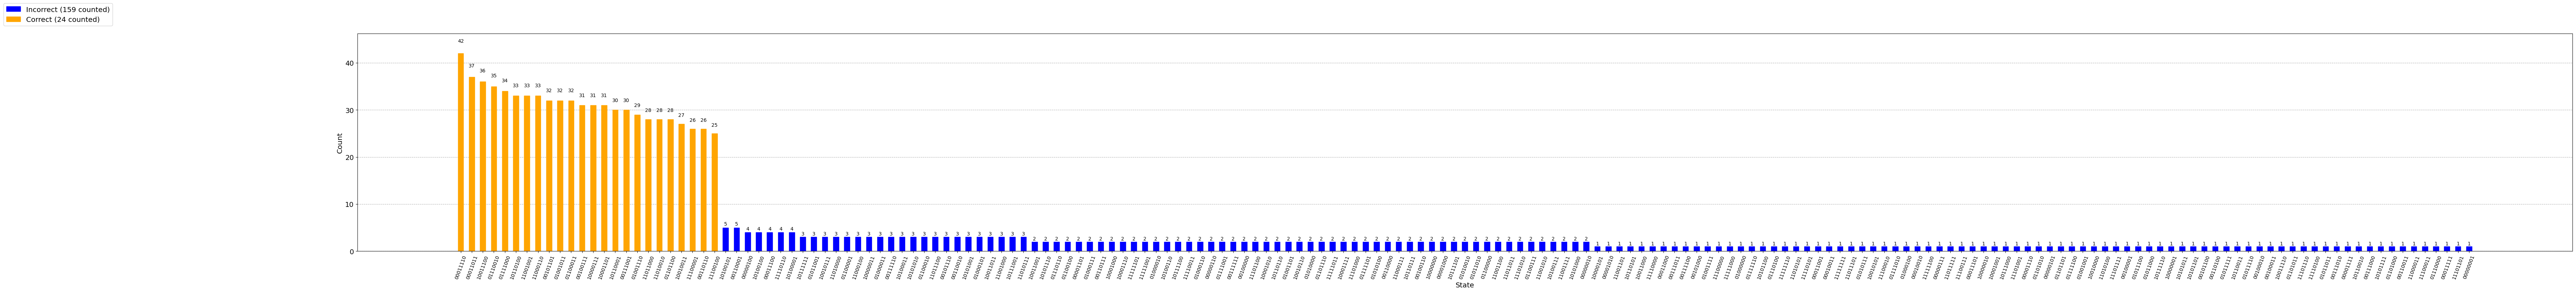

In [36]:
plot_results(results, check_disagreement)